In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('./data/movieData.csv', parse_dates=['Thursday'])
df['dayofyear'] = df.groupby('name')['Thursday'].transform(lambda x: x.dt.dayofyear)
df['name'] = df['name'].str.lower()
df.head()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,Thursday,name,year,Winner,dayofyear
0,17.0,967378,NaN,14.0,NaN,69098.0,967378,1,1990-11-18,dances with wolves,1990,True,322
1,9.0,3871641,300.0,14.0,NaN,276546.0,4839019,2,1990-11-25,dances with wolves,1990,True,329
2,3.0,12547813,224.0,1048.0,1034.0,11973.0,17386832,3,1990-12-02,dances with wolves,1990,True,336
3,4.0,9246632,-26.3,1053.0,5.0,8781.0,26633464,4,1990-12-09,dances with wolves,1990,True,343
4,4.0,7272350,-21.4,1051.0,-2.0,6919.0,33905814,5,1990-12-16,dances with wolves,1990,True,350


## Look at it all

I want to cheat it so we don't have this carry over when something is released in Dec

Text(0.5,0,'')

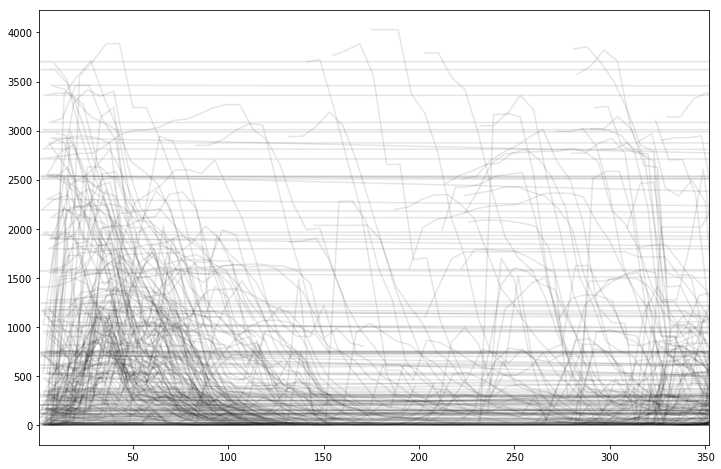

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = df.groupby('name').plot(x='dayofyear', y='Theaters', ax=ax, color='k', alpha=.1)
ax.legend().set_visible(False)
ax.set_xlabel('')

This is more like it

Text(0.5,0,'')

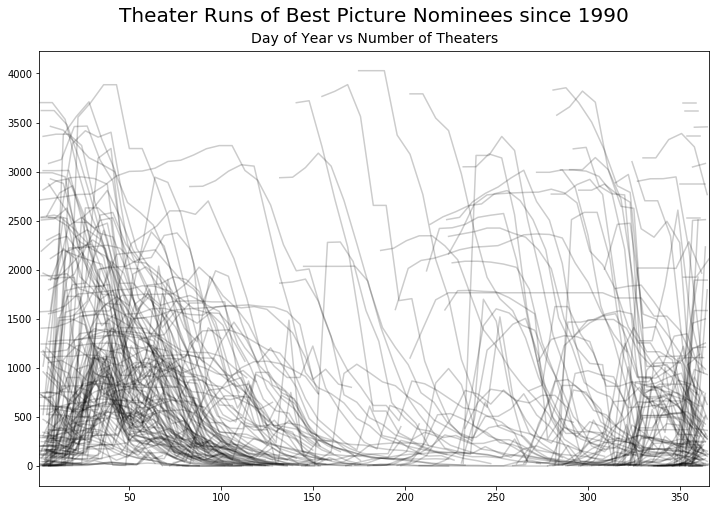

In [5]:
yrs = df['Thursday'].dt.year
fig, ax = plt.subplots(figsize=(12, 8))


_ = df.groupby(['name', yrs]).plot(x='dayofyear', y='Theaters', ax=ax, color='k', alpha=.2)
ax.legend().set_visible(False)

ymax = ax.get_ylim()[1]
ax.text(np.average(ax.get_xlim()), ymax*1.07, 'Theater Runs of Best Picture Nominees since 1990',
        fontdict={'size':20, 'ha':'center'})
ax.text(np.average(ax.get_xlim()), ymax*1.02, 'Day of Year vs Number of Theaters',
        fontdict={'size':14, 'ha':'center'})
ax.set_xlabel('')

## Pemieres

In [6]:
premieres = df.groupby('name').first().reset_index()
premieres.head()

,name,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,Thursday,year,Winner,dayofyear
0,12 years a slave,15.0,1259943,130.0,19.0,104.0,66313.0,1259943,1,2013-10-24,2013,True,297
1,127 hours,27.0,372989,64.3,4.0,18.0,93247.0,372989,1,2010-11-11,2010,False,315
2,a beautiful mind,13.0,5930676,158.0,11.0,514.0,539152.0,5930676,1,2001-12-27,2001,True,361
3,a few good men,1.0,20856522,-18.6,1925.0,187.0,10835.0,20856522,1,1992-12-17,1992,False,352
4,a serious man,29.0,351986,84.3,6.0,15.0,58664.0,351986,1,2009-10-08,2009,False,281


If you had the sneaking suspicion that more movies were releasing closer to the end of the year, you were right.

Text(0.5,1,'Best Picture Nominee Premiere by Day of Year')

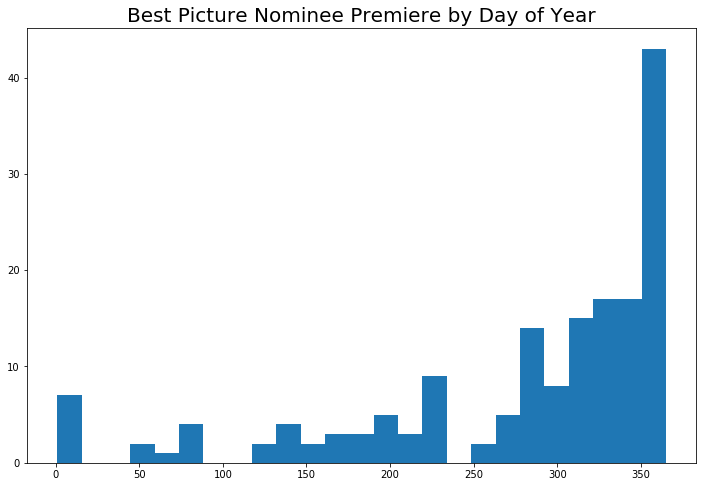

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(premieres['Thursday'].dt.dayofyear, bins=25)
ax.set_title('Best Picture Nominee Premiere by Day of Year', size=20)

That trend has only gotten worse as time goes on.

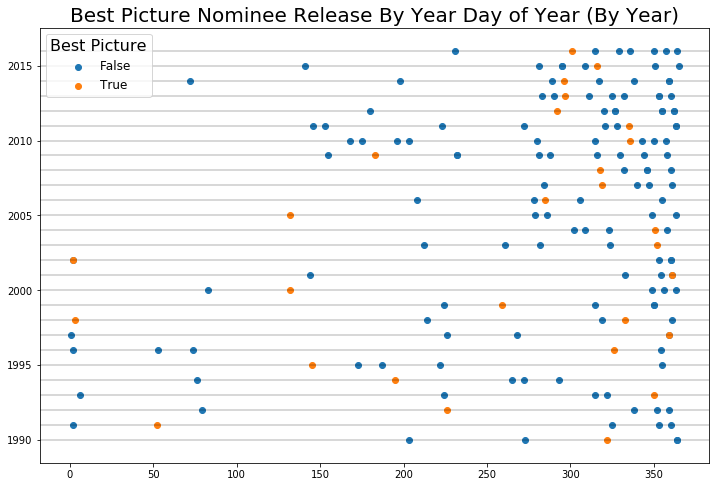

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in premieres.groupby('Winner'):
    ax.scatter(group['Thursday'].dt.dayofyear, group['year'], label=name)
    _ = [ax.axhline(i, color='k', alpha=.1) for i in range(1990, 2017)]
    ax.set_title('Best Picture Nominee Release By Year Day of Year (By Year)', size=20)

ax.legend(fontsize=12).set_title('Best Picture', prop={'size':16})

In fact, if we partition each year into 4 buckets:

    [0, 100), [100, 200), [200, 300), [300, 365]

In [9]:
fn = lambda x: pd.cut(x, bins=[0, 100, 200, 300, 365], labels=['1st', '2nd', '3rd', '4th'])
premieres['releaseQuarter'] = premieres.groupby('year')['dayofyear'].apply(fn)

releasePctByQuarter = premieres.groupby('year')['releaseQuarter'].value_counts().unstack().fillna(0)

We see that the number of movies releasing in the last stretch of the year has gone up over time

Text(0.5,1,'Premiere Release by Quarter')

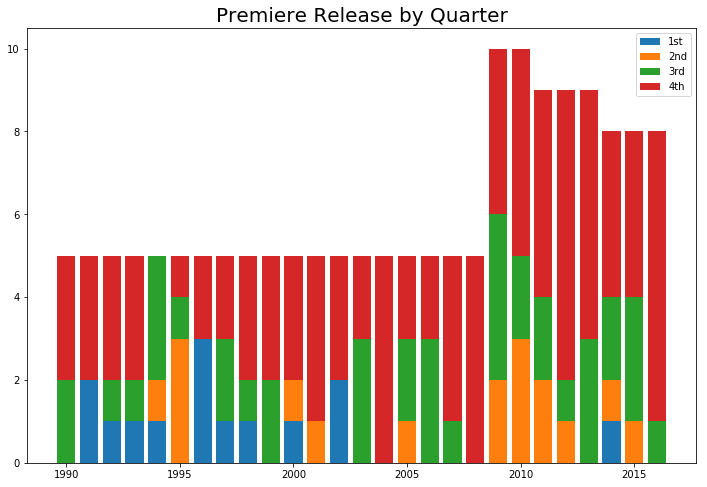

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

x = releasePctByQuarter.index
y1, y2, y3, y4 = [releasePctByQuarter[x].values for x in releasePctByQuarter]
ax.bar(x, y1)
ax.bar(x, y2, bottom=y1)
ax.bar(x, y3, bottom=y2+y1)
ax.bar(x, y4, bottom=y3+y2+y1)
plt.legend(releasePctByQuarter.columns)

ax.set_title('Premiere Release by Quarter', size=20)

### Release vs Award Data

To figure out what the Academy's got to do with it, we'll use the dataset from last time

In [11]:
academy = pd.read_csv('./data/oscarsDates.csv', parse_dates=['announcement', 'show'])
academy.head()

,year,announcement,show,best_picture_noms,nielsen
0,2016,2017-01-24,2017-02-26,9,32.9
1,2015,2016-01-14,2016-02-28,8,34.4
2,2014,2015-01-15,2015-02-22,8,37.3
3,2013,2014-01-16,2014-03-02,9,43.7
4,2012,2013-01-10,2013-02-24,9,40.4


Let's look at the relationship between the award shows and premiere data

In [12]:
allIn_pre = premieres.merge(academy)

allIn_pre['days_before_announcement'] = (allIn_pre['announcement'] - allIn_pre['Thursday']).dt.days
allIn_pre['days_before_show'] = (allIn_pre['show'] - allIn_pre['Thursday']).dt.days

Is there trending in the difference between release date and award show?

Text(0.5,1,'Days Between Movie Premiere and Announcement')

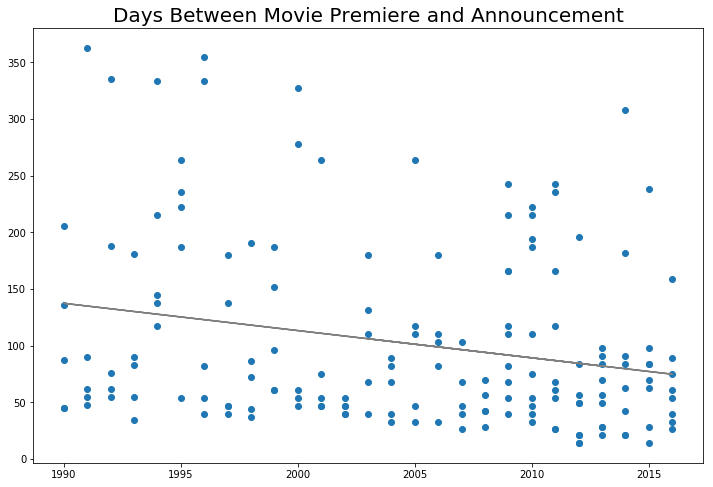

In [13]:
X = allIn_pre['year']
y = allIn_pre['days_before_announcement']
a, b = np.polyfit(X, y, 1)
yfit = [b + a * xi for xi in X]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.plot(X, yfit, color='gray')
ax.set_title('Days Between Movie Premiere and Announcement', size=20)

Removing some of the noise through averages tells a slightly-more-compelling story.

Text(0.5,1,'Average Days Between Release and Announcement')

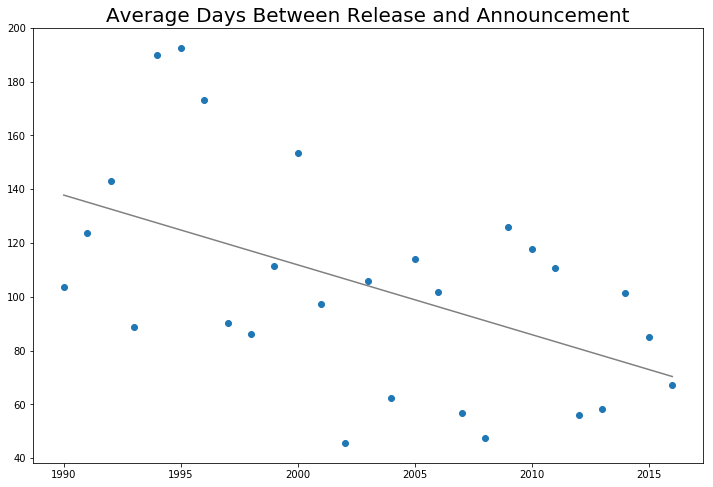

In [14]:
y = allIn_pre.groupby('year')['days_before_announcement'].mean()
X = y.index
a, b = np.polyfit(X, y, 1)
yfit = [b + a * xi for xi in X]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.plot(X, yfit, 'gray')
ax.set_title('Average Days Between Release and Announcement', size=20)

Looking at correlations, not much here besides

- inverse relationship between opening rank and nielsen numbers

In [15]:
allIn_pre.corr()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,year,Winner,dayofyear,best_picture_noms,nielsen,days_before_announcement,days_before_show
Rank,1.000000,-0.520855,-0.078554,-0.668505,0.101866,0.098628,-0.521083,-0.191599,0.247107,-0.048709,0.151739,0.021397,-0.268496,-0.209932,-0.216378
WeeklyGross,-0.520855,1.000000,-0.047451,0.800905,-0.226338,-0.209603,0.999676,0.016594,0.042938,-0.005915,-0.115980,0.177862,0.053745,0.193774,0.192676
PctChangeWkGross,-0.078554,-0.047451,1.000000,-0.061347,0.323784,-0.054338,-0.047816,-0.090960,0.046036,-0.038271,-0.030050,0.126831,0.004833,0.055181,0.050177
Theaters,-0.668505,0.800905,-0.061347,1.000000,-0.283972,-0.378425,0.799932,-0.092980,0.021244,0.002931,-0.038752,0.110093,0.077585,0.133759,0.137617
DeltaTheaters,0.101866,-0.226338,0.323784,-0.283972,1.000000,0.238771,-0.227504,-0.032451,0.114748,-0.108102,0.172267,0.088144,-0.129532,-0.165764,-0.166658
AvgRev,0.098628,-0.209603,-0.054338,-0.378425,0.238771,1.000000,-0.211881,0.068375,0.194613,0.082364,0.041864,0.150735,-0.194527,-0.031332,-0.034727
GrossToDate,-0.521083,0.999676,-0.047816,0.799932,-0.227504,-0.211881,1.000000,0.033065,0.039502,-0.006202,-0.123357,0.175229,0.055075,0.198895,0.197909
Week,-0.191599,0.016594,-0.090960,-0.092980,-0.032451,0.068375,0.033065,1.000000,-0.178868,0.035624,-0.430388,-0.093995,0.108488,0.158569,0.162405
year,0.247107,0.042938,0.046036,0.021244,0.114748,0.194613,0.039502,-0.178868,1.000000,-0.106386,0.242722,0.776033,-0.626758,-0.236434,-0.246647
Winner,-0.048709,-0.005915,-0.038271,0.002931,-0.108102,0.082364,-0.006202,0.035624,-0.106386,1.000000,-0.102847,-0.129475,0.055509,0.076516,0.077034


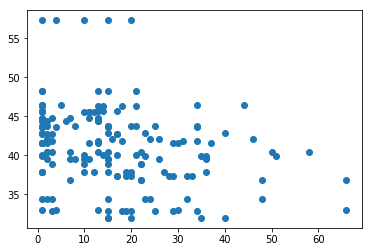

In [16]:
plt.scatter(allIn_pre['Rank'], allIn_pre['nielsen'])

### What about the last week for each movie?

In [17]:
closings = df.groupby('name').last().reset_index()
closings.head()

,name,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,Thursday,year,Winner,dayofyear
0,12 years a slave,72.0,12460,-49.6,20.0,-12.0,623.0,56671993,29,2014-05-08,2013,True,128
1,127 hours,72.0,11084,-24.5,12.0,-6.0,924.0,18335230,23,2011-04-14,2010,False,104
2,a beautiful mind,28.0,177775,-25.1,202.0,-91.0,880.0,170742341,23,2002-05-30,2001,True,150
3,a few good men,17.0,255462,-54.9,204.0,-194.0,1252.0,140384814,25,1993-06-03,1992,False,154
4,a serious man,35.0,130332,7.0,49.0,-68.0,2660.0,9228768,14,2010-01-07,2009,False,7


In [18]:
allIn_post = closings.merge(academy)

allIn_post['days_after_show'] = (allIn_post['Thursday'] - allIn_post['show']).dt.days
allIn_post['days_after_announcement'] = (allIn_post['Thursday'] - allIn_post['announcement']).dt.days

Here we see:

- Movies that win have a longer tail
- Nielsen ratings correlated with and Theaters
- Weakly Correlated with Avg Rev and Gross to Date

In [19]:
allIn_post.corr()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,year,Winner,dayofyear,best_picture_noms,nielsen,days_after_show,days_after_announcement
Rank,1.000000,-0.617452,-0.119604,-0.682649,0.016429,-0.282136,-0.014776,0.231966,0.606678,-0.136029,-0.088531,0.297293,-0.521517,0.421983,0.408920
WeeklyGross,-0.617452,1.000000,0.054838,0.957211,-0.016262,0.410729,-0.074766,-0.229012,-0.552578,0.128781,-0.003433,-0.285077,0.399153,-0.344551,-0.335647
PctChangeWkGross,-0.119604,0.054838,1.000000,0.108951,-0.092226,0.023123,0.052240,-0.045197,-0.128992,-0.039677,0.197298,-0.063811,0.087774,-0.141255,-0.139367
Theaters,-0.682649,0.957211,0.108951,1.000000,0.004865,0.324820,-0.040351,-0.247179,-0.599402,0.115564,-0.038510,-0.318277,0.428053,-0.310772,-0.299843
DeltaTheaters,0.016429,-0.016262,-0.092226,0.004865,1.000000,0.045200,-0.146782,-0.113368,-0.054992,-0.123541,0.001334,-0.024310,-0.054119,-0.118937,-0.117886
AvgRev,-0.282136,0.410729,0.023123,0.324820,0.045200,1.000000,0.266064,-0.091579,-0.231265,-0.019362,0.078873,-0.032456,0.156360,-0.217050,-0.218406
GrossToDate,-0.014776,-0.074766,0.052240,-0.040351,-0.146782,0.266064,1.000000,0.290187,-0.009630,0.141361,0.193626,0.075708,0.122394,0.238091,0.239600
Week,0.231966,-0.229012,-0.045197,-0.247179,-0.113368,-0.091579,0.290187,1.000000,-0.003414,0.350138,0.012761,-0.083443,0.069447,0.305597,0.307392
year,0.606678,-0.552578,-0.128992,-0.599402,-0.054992,-0.231265,-0.009630,-0.003414,1.000000,-0.106386,-0.114683,0.776033,-0.626758,0.284893,0.276476
Winner,-0.136029,0.128781,-0.039677,0.115564,-0.123541,-0.019362,0.141361,0.350138,-0.106386,1.000000,0.038184,-0.129475,0.055509,0.116629,0.117425


It's more telling to actually look at movies that stuck around after the show

In [20]:
actual_post = allIn_post[allIn_post['days_after_show'] > 0]

In [21]:
actual_post.corr()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,year,Winner,dayofyear,best_picture_noms,nielsen,days_after_show,days_after_announcement
Rank,1.000000,-0.532346,-0.110374,-0.624732,0.372835,-0.143533,-0.080723,0.102088,0.476778,-0.228418,0.071254,0.211078,-0.434686,0.238212,0.203557
WeeklyGross,-0.532346,1.000000,0.071559,0.971604,-0.450311,0.270226,-0.013277,-0.146041,-0.429187,0.168212,-0.138784,-0.172289,0.246183,-0.269516,-0.251197
PctChangeWkGross,-0.110374,0.071559,1.000000,0.088248,0.313487,0.113436,0.038706,0.030721,0.144567,0.011128,0.076496,0.193242,-0.154057,0.081163,0.080944
Theaters,-0.624732,0.971604,0.088248,1.000000,-0.422517,0.233198,-0.005454,-0.166902,-0.484370,0.149126,-0.151827,-0.209069,0.308242,-0.305676,-0.281293
DeltaTheaters,0.372835,-0.450311,0.313487,-0.422517,1.000000,-0.121170,-0.071096,0.044680,0.337055,-0.167200,0.042165,0.163459,-0.328102,0.123585,0.114397
AvgRev,-0.143533,0.270226,0.113436,0.233198,-0.121170,1.000000,0.469484,0.010481,-0.084712,-0.010121,0.111132,0.068526,0.026561,0.080148,0.068650
GrossToDate,-0.080723,-0.013277,0.038706,-0.005454,-0.071096,0.469484,1.000000,0.286638,-0.103588,0.121348,0.505796,0.018975,0.227920,0.490474,0.494289
Week,0.102088,-0.146041,0.030721,-0.166902,0.044680,0.010481,0.286638,1.000000,-0.262160,0.292288,0.474116,-0.155881,0.220842,0.420882,0.421952
year,0.476778,-0.429187,0.144567,-0.484370,0.337055,-0.084712,-0.103588,-0.262160,1.000000,-0.196584,-0.288784,0.769646,-0.589831,-0.046629,-0.053146
Winner,-0.228418,0.168212,0.011128,0.149126,-0.167200,-0.010121,0.121348,0.292288,-0.196584,1.000000,0.226822,-0.157687,0.107660,0.198074,0.201545


In [22]:
readable = lambda x: '{:,.2f}'.format(x)
actual_post.groupby('Winner')['Week', 'GrossToDate'].describe().T.applymap(readable)

Winner                      False           True 
Week        count           98.00           23.00
            mean            24.19           29.96
            std              7.12            8.81
            min             13.00           18.00
            25%             19.00           24.50
            50%             23.00           28.00
            75%             28.00           32.50
            max             45.00           55.00
GrossToDate count           98.00           23.00
            mean    99,319,145.86  131,823,479.39
            std     99,892,785.66  125,940,639.04
            min      6,531,503.00   27,854,932.00
            25%     37,863,170.00   64,220,978.00
            50%     71,331,069.00  100,465,073.00
            75%    132,070,843.25  138,661,251.00
            max    749,766,139.00  600,683,057.00

## Effect of announcement on theaters

In [23]:
def plot_year_releases(df, year):
    thick_dict = {True:3, False:1}
    fig, ax = plt.subplots(figsize=(16, 8))
    for name, group in df[df['year'] == year].groupby('name'):        
        won = group['Winner'].max()
        group.plot(x='Thursday', y='Theaters', ax=ax, label=name, linewidth=thick_dict[won])
        announcement, show = academy[academy['year'] == year][['announcement', 'show']].values[0]
        plt.axvline(pd.Timestamp(announcement), c='k', alpha=.2)
        plt.axvline(pd.Timestamp(show), c='k', alpha=.2)
    
    
    ymax = ax.get_ylim()[1]
    ax.text(np.average(ax.get_xlim()), ymax*1.07, 'Popularity of Best Picture Nominees in {}'.format(year),
        fontdict={'size':20, 'ha':'center'})
    ax.text(np.average(ax.get_xlim()), ymax*1.02, 'vs Nominee Announcement and Show Dates'.format(year),
        fontdict={'size':14, 'ha':'center'})
    ax.legend(fontsize=12)
    ax.text(0, 0, '')
    ax.set_ylabel('Theaters', fontsize=12)
    ax.set_xlabel('')
    return ax

Starts off pretty boring

(-83.5, 2017.5)

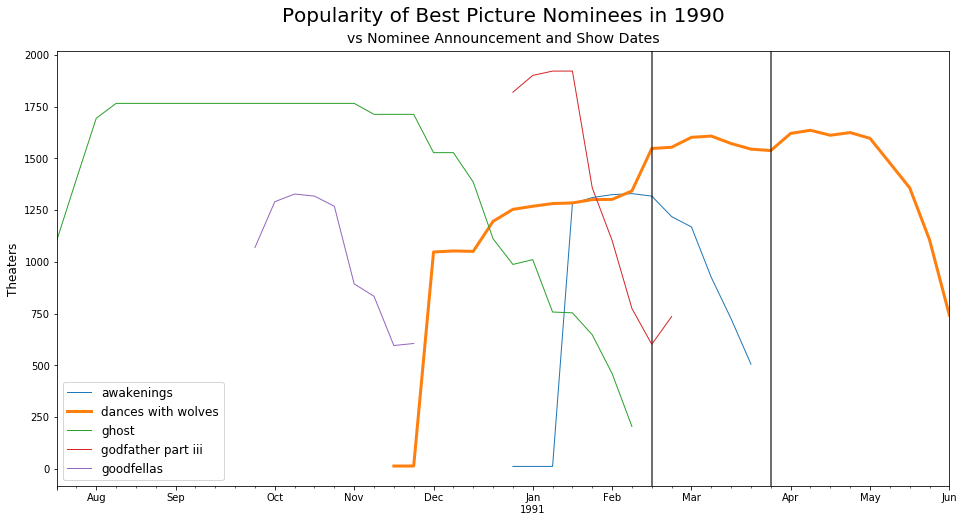

In [24]:
ax = plot_year_releases(df, 1990)
ax.get_ylim()

Curiously, Silence of the Lambs was way before everything else

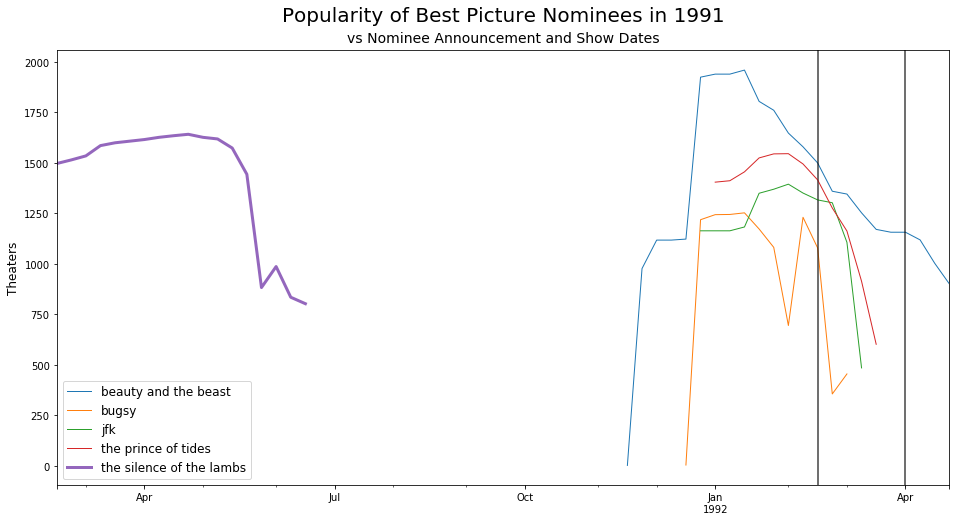

In [25]:
plot_year_releases(df, 1991)

The Crying Game

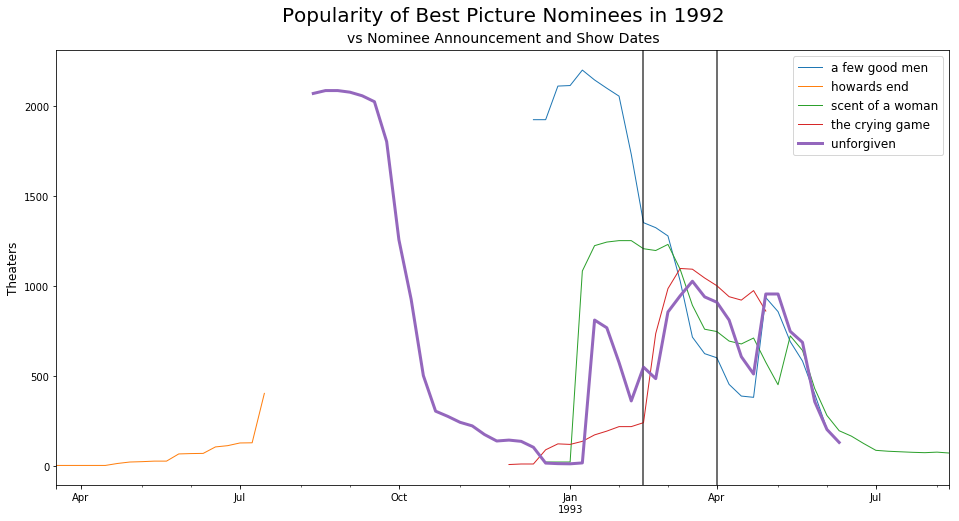

In [26]:
plot_year_releases(df, 1992)

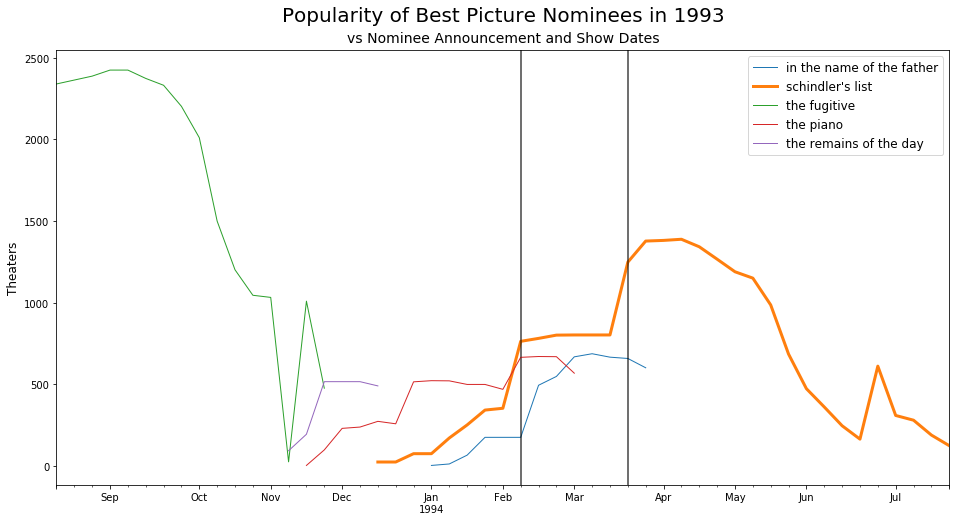

In [27]:
plot_year_releases(df, 1993)

94-96 were boring

In [28]:
# plot_year_releases(df, 1996)

Titanic won, and that was huge

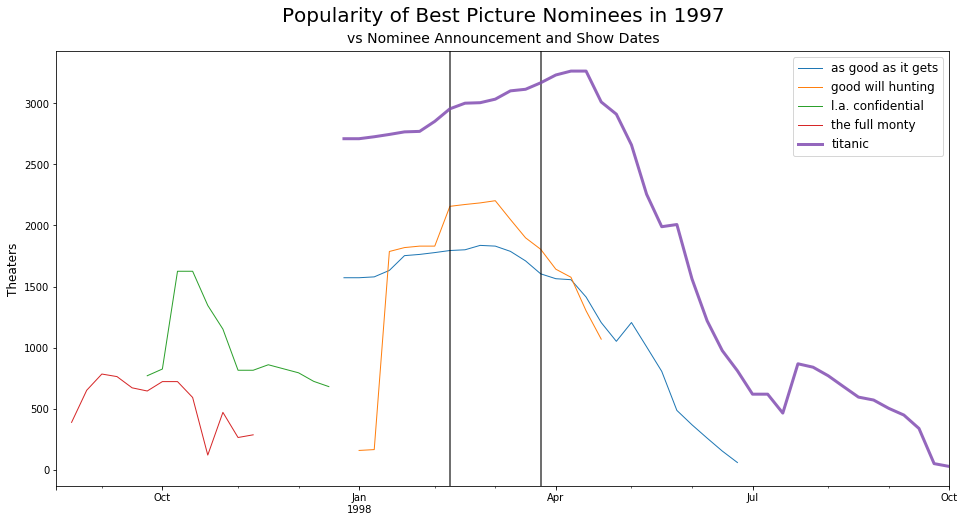

In [29]:
plot_year_releases(df, 1997)

American Beauty drops off hard, and then the announcement

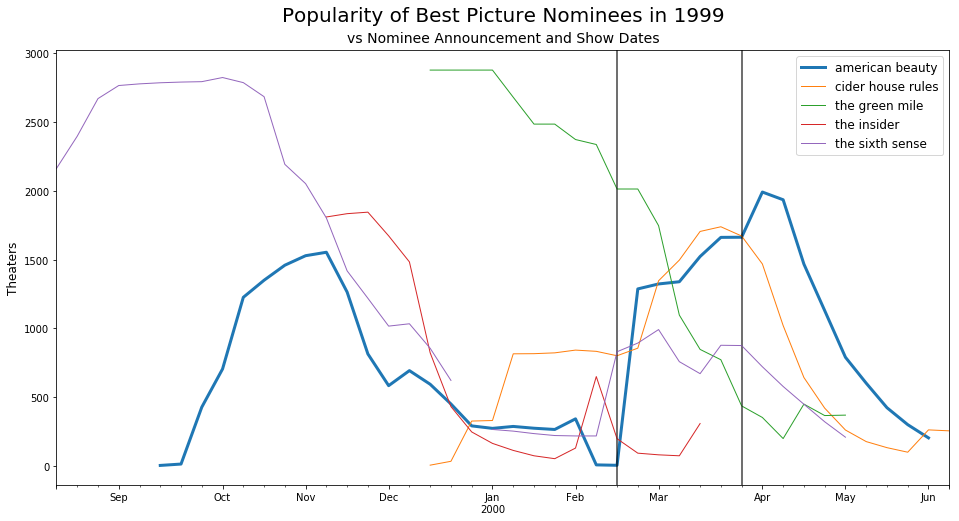

In [30]:
plot_year_releases(df, 1999)

Oscar Buzz started happening.

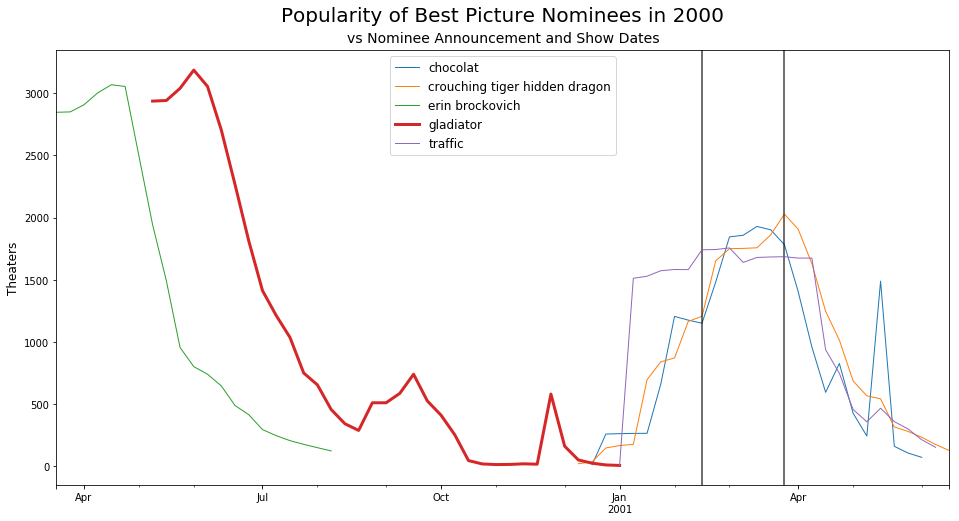

In [31]:
plot_year_releases(df, 2000)

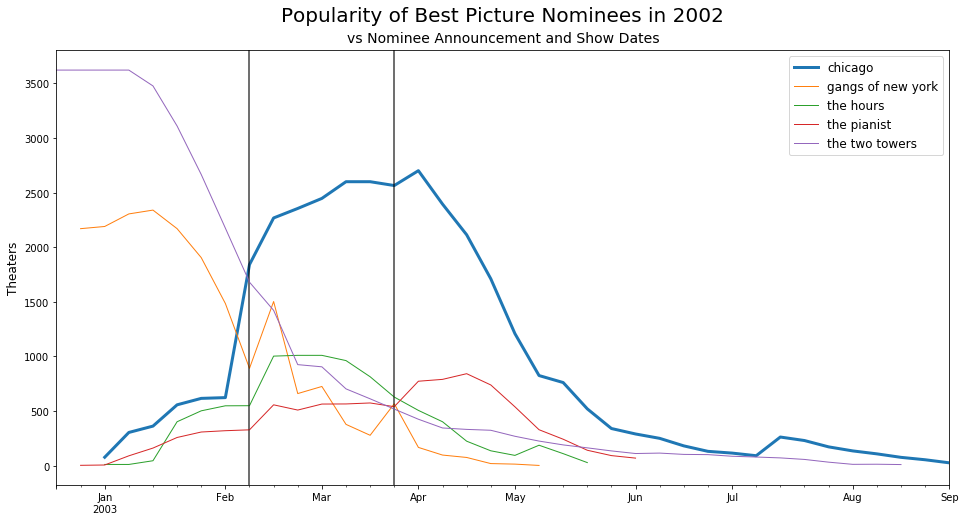

In [32]:
plot_year_releases(df, 2002)

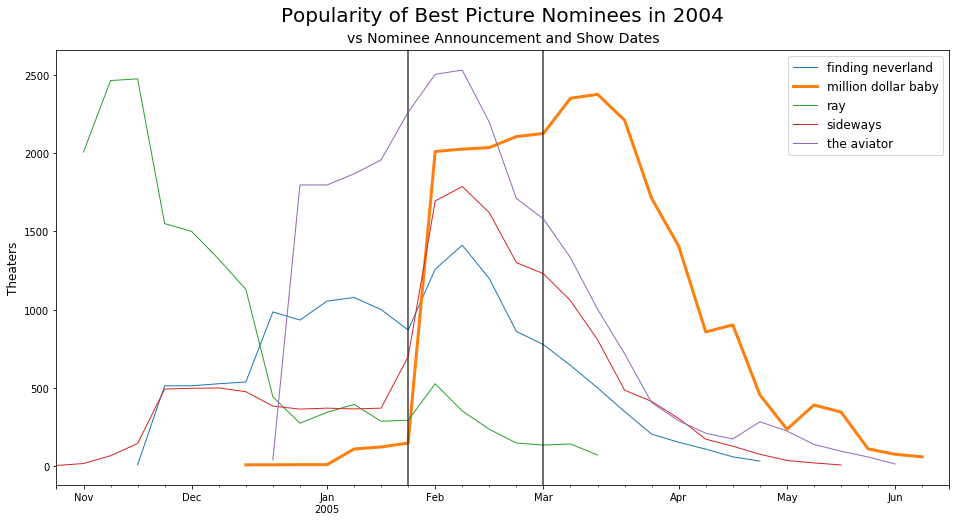

In [33]:
plot_year_releases(df, 2004)

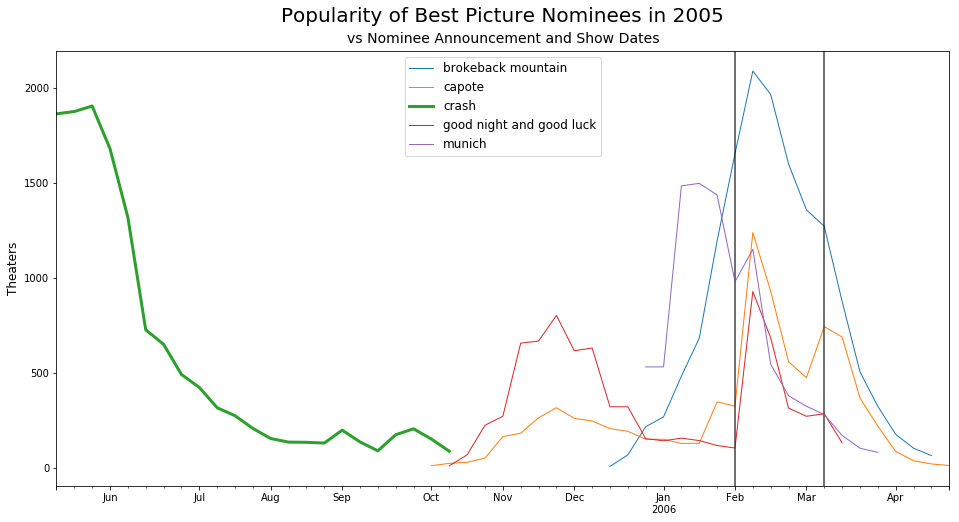

In [34]:
plot_year_releases(df, 2005)

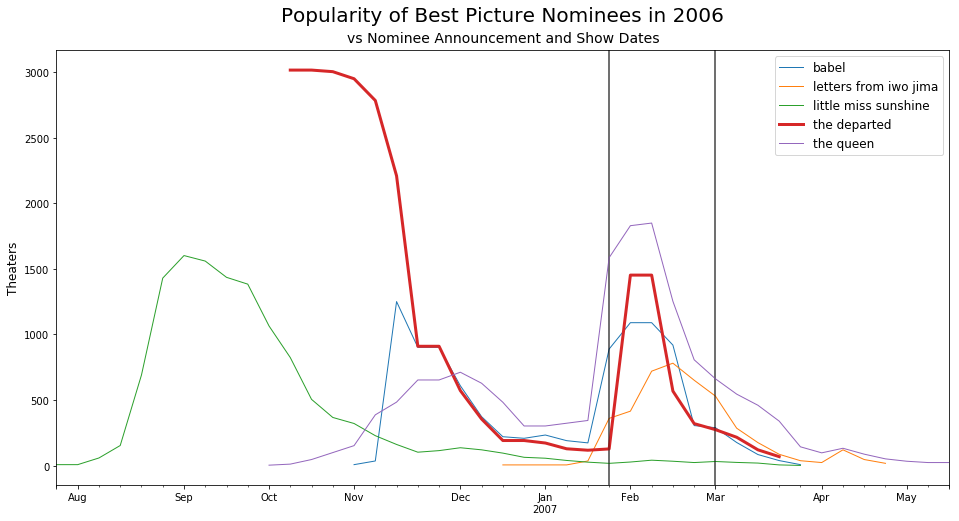

In [35]:
plot_year_releases(df, 2006)

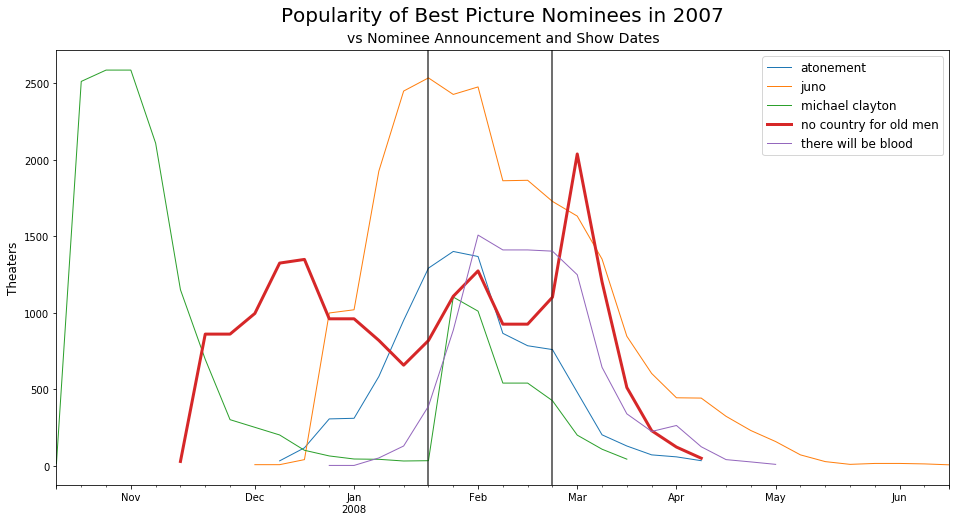

In [36]:
plot_year_releases(df, 2007)

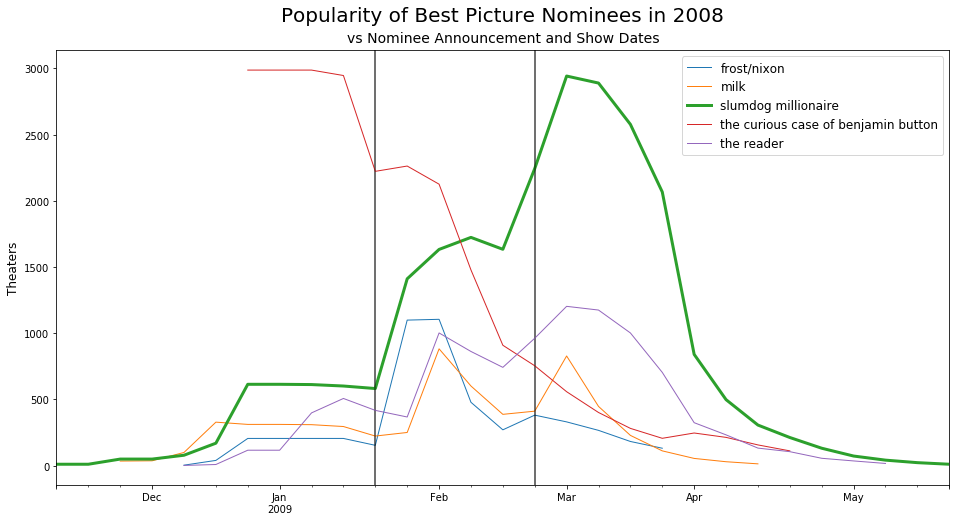

In [37]:
plot_year_releases(df, 2008)

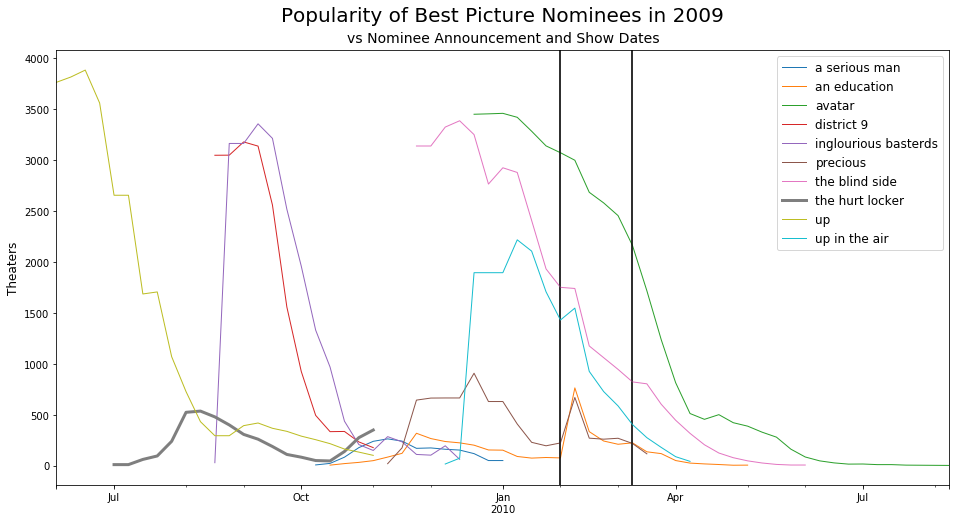

In [38]:
plot_year_releases(df, 2009)

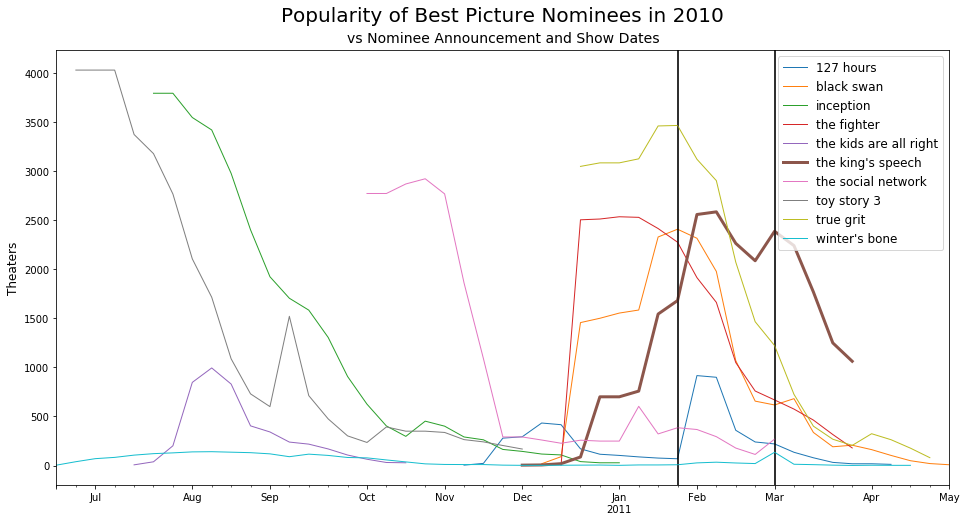

In [39]:
plot_year_releases(df, 2010)

### Wait, what the hell just won?

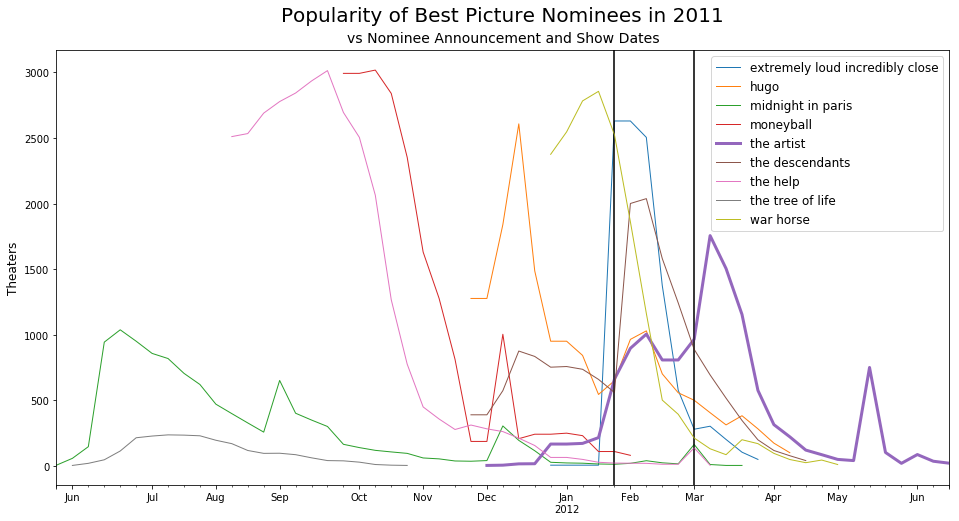

In [40]:
plot_year_releases(df, 2011)

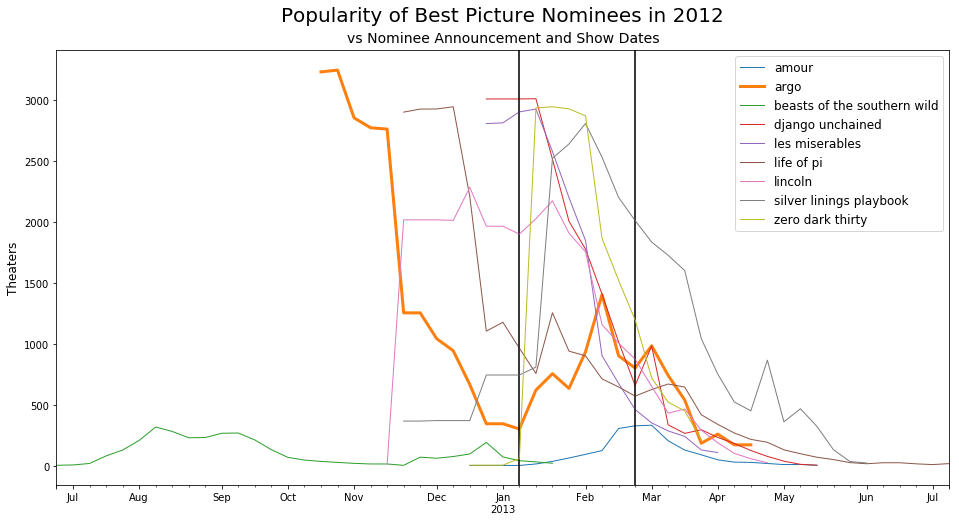

In [41]:
plot_year_releases(df, 2012)

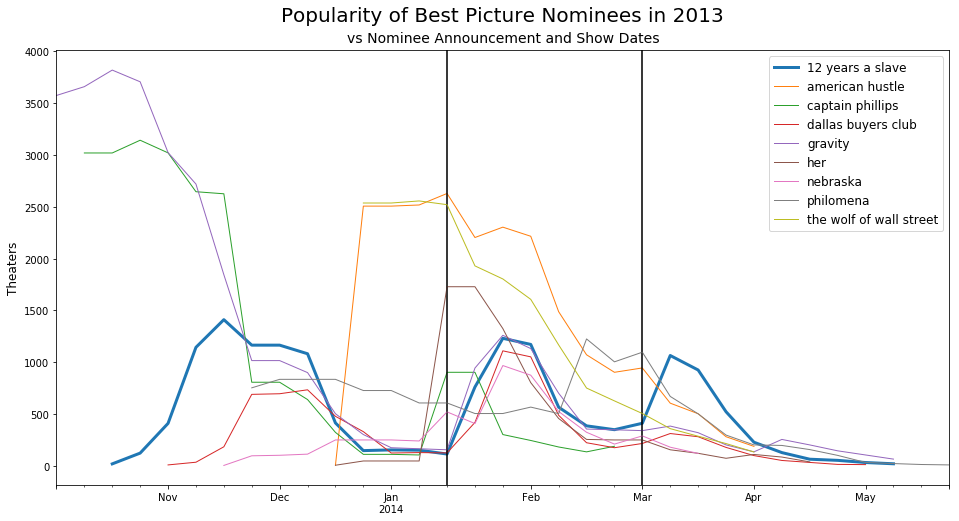

In [42]:
plot_year_releases(df, 2013)

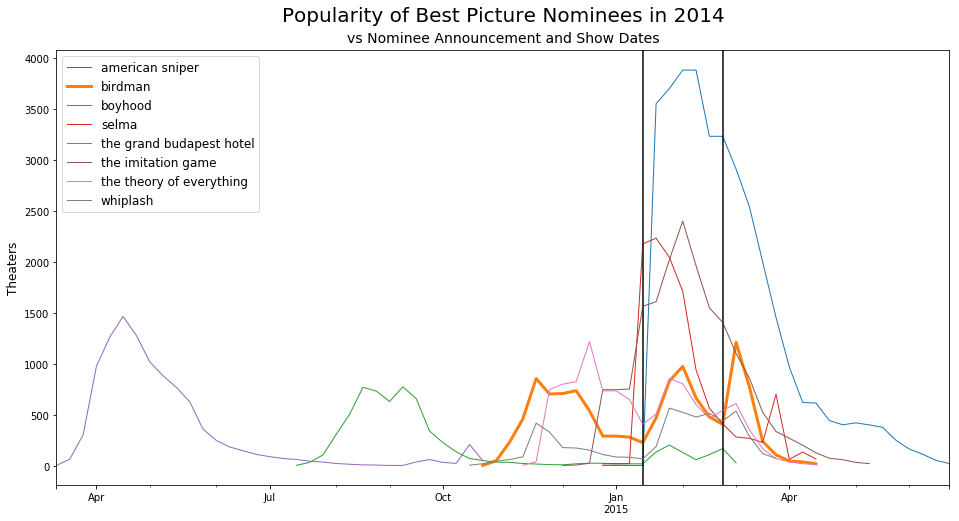

In [43]:
plot_year_releases(df, 2014)

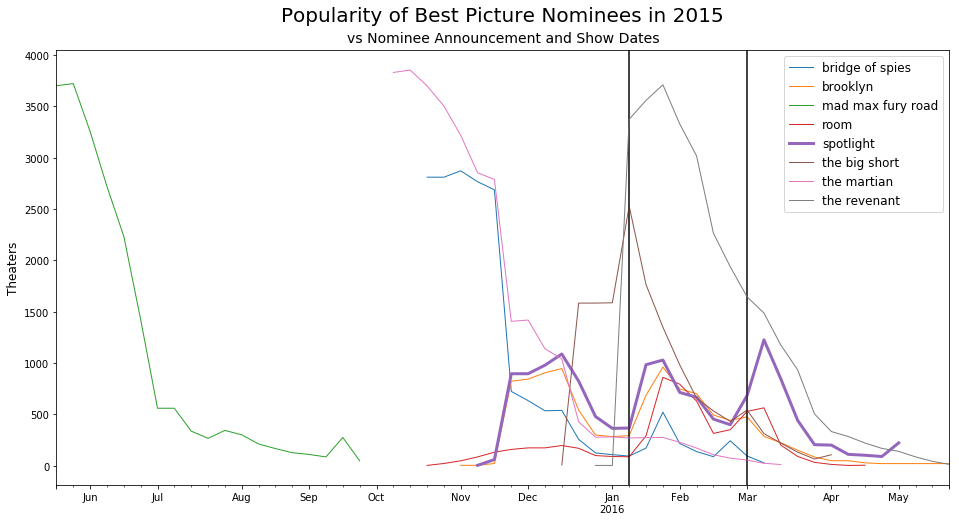

In [44]:
plot_year_releases(df, 2015)

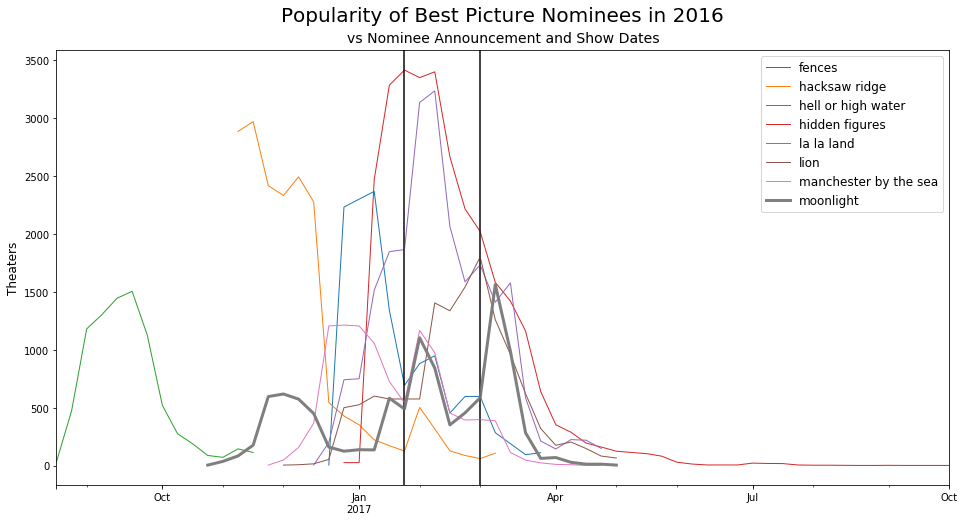

In [45]:
plot_year_releases(df, 2016)

## So how important is that announcement?

Before I can answer that, I needed to get a quick pulse on how the industry was looking

Text(2009.5,1.7e+08,'...right behind Avatar.')

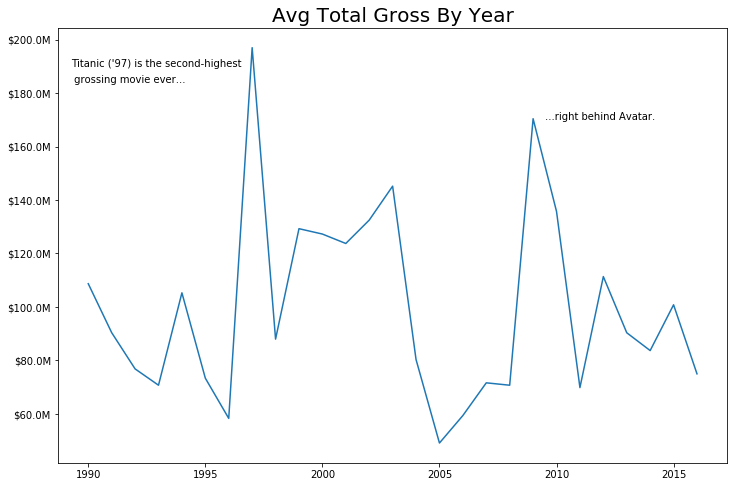

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(closings.groupby('year')['GrossToDate'].mean())
ax.set_title('Avg Total Gross By Year', size=20)
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

ax.yaxis.set_major_formatter(FuncFormatter(millions))

# 204382179
ax.annotate("Titanic ('97) is the second-highest", (1989.25, 1.90*10**8))
ax.annotate(' grossing movie ever...', (1989.25, 1.84*10**8))
ax.annotate('...right behind Avatar.', (2009.5, 1.70*10**8))

Text(0.5,1,'Total Gross By Movie')

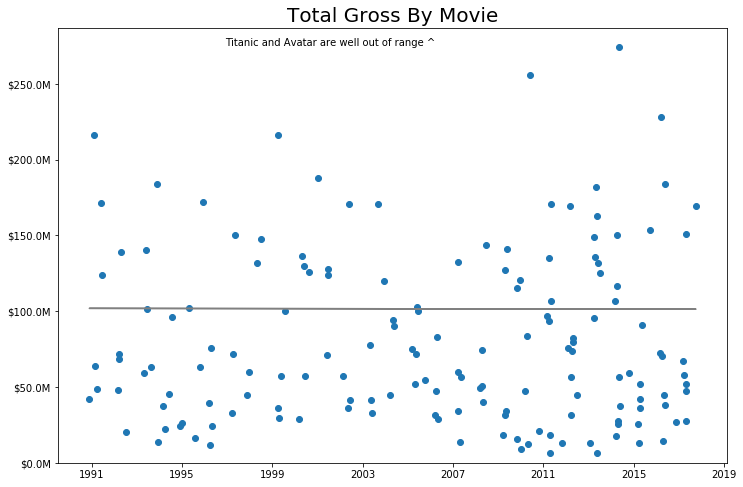

In [47]:
X = closings['Thursday']
X_float = np.asarray(X, np.float64)
y = closings['GrossToDate']
a, b = np.polyfit(X_float, y, 1)
yfit = [b + a * xi for xi in X_float]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(pd.DatetimeIndex(X), y)
ax.plot(X, yfit, color='gray')

ax.set_ylim(0, 286927870)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

ax.yaxis.set_major_formatter(FuncFormatter(millions))
ax.annotate("Titanic and Avatar are well out of range ^", (729000, 275000000))
ax.set_title('Total Gross By Movie', size=20)

## How much money is there to make after the show?

It's more telling to actually look at movies that stuck around after the show

In [48]:
final = df.merge(academy)
final.head()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,Thursday,name,year,Winner,dayofyear,announcement,show,best_picture_noms,nielsen
0,17.0,967378,NaN,14.0,NaN,69098.0,967378,1,1990-11-18,dances with wolves,1990,True,322,1991-02-13,1991-03-25,5,42.7
1,9.0,3871641,300.0,14.0,NaN,276546.0,4839019,2,1990-11-25,dances with wolves,1990,True,329,1991-02-13,1991-03-25,5,42.7
2,3.0,12547813,224.0,1048.0,1034.0,11973.0,17386832,3,1990-12-02,dances with wolves,1990,True,336,1991-02-13,1991-03-25,5,42.7
3,4.0,9246632,-26.3,1053.0,5.0,8781.0,26633464,4,1990-12-09,dances with wolves,1990,True,343,1991-02-13,1991-03-25,5,42.7
4,4.0,7272350,-21.4,1051.0,-2.0,6919.0,33905814,5,1990-12-16,dances with wolves,1990,True,350,1991-02-13,1991-03-25,5,42.7


In [49]:
weekAfterAnnouncement = final['Thursday'] >= final['announcement']
splitGross = final.groupby(['year',  weekAfterAnnouncement])['WeeklyGross'].apply(sum)
totalGross = final.groupby(['year'])['WeeklyGross'].apply(sum)

stackdata = (splitGross / totalGross).unstack()

Text(0.5,1,'Avg Total Gross After Announcement as % of Total Gross All-In')

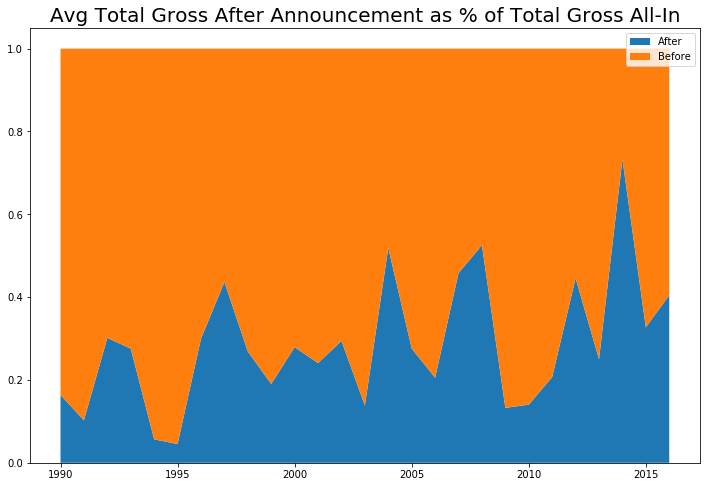

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(stackdata.index, stackdata[True], stackdata[False], labels=['After', 'Before'])
ax.legend()
ax.set_title('Avg Total Gross After Announcement as % of Total Gross All-In', size=20)

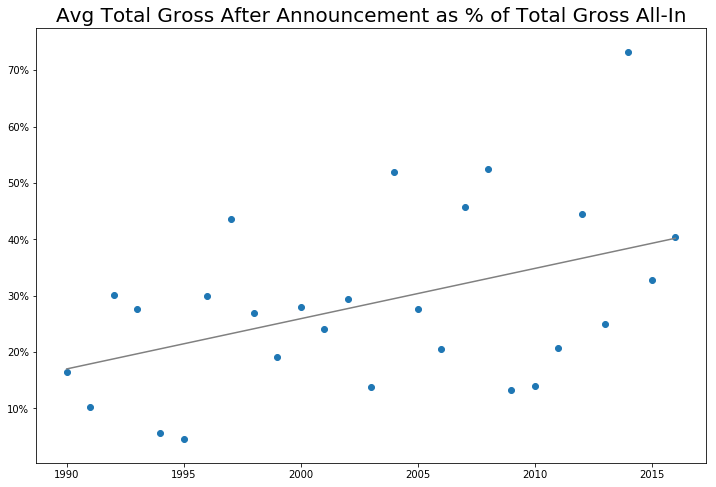

In [51]:
X = stackdata.index
X_float = np.asarray(X, np.float64)
y = stackdata[True]
a, b = np.polyfit(X_float, y, 1)
yfit = [b + a * xi for xi in X_float]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.plot(X, yfit, color='gray')
ax.set_title('Avg Total Gross After Announcement as % of Total Gross All-In', size=20)
_ = ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])

[Nominees](http://ew.com/awards/2018/01/02/when-are-the-golden-globes/)

Best Motion Picture – Drama

    x Call Me By Your Name
      Dunkirk
    x The Post
    x The Shape of Water
    x Three Billboards Outside Ebbing, Missouri

Best Motion Picture – Musical or Comedy
    
    x The Disaster Artist
      Get Out
    x The Greatest Showman
    x I, Tonya
    x Lady Bird